### EEGFormer for The TUH Abnormal EEG Corpus (TUAB) dataset
#### In this notebook, the full pipeline is: load data ->  preprocess (crop 10s, resample to 128 Hz, band-pass 0.5–40 Hz, pick 16 channels) -> load model -> train model -> save .pkl and plots
##### EEGFormer on TUAB dataset: 
1. This training behavior indicates severe overfitting, where the model perfectly fits the training distribution while progressively increasing its confidence on incorrect test predictions. The statistical structure learned from the training set is not preserved in the test set, causing the model to reinforce incorrect predictions with increasing confidence.
2. Possible reason: The training data contain strong correlations or redundancies, enabling the model to memorize training samples without learning robust decision boundaries.
3. Possible improvements: Reducing temporal redundancy in window sampling;  Applying early stopping or confidence-regularizing strategies.

In [1]:
import os
import sys
from pathlib import Path
import random
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import mne
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
cwd = Path.cwd()
project_root = cwd.parents[1]
sys.path.append(str(project_root))

from EEGformer.models import EEGformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
root = project_root
tuab_root = root / "data" / "tuh_eeg" / "v3.0.1" / "edf"

train_normal_dir   = tuab_root / "train" / "normal"
train_abnormal_dir = tuab_root / "train" / "abnormal"

def list_edf_files(folder: Path):
    return sorted([p for p in folder.rglob("*.edf") if p.is_file()])

normal_files = list_edf_files(train_normal_dir)
abnormal_files = list_edf_files(train_abnormal_dir)

print("Found normal EDF:", len(normal_files))
print("Found abnormal EDF:", len(abnormal_files))
print("Example normal:", normal_files[0] if normal_files else None)
print("Example abnormal:", abnormal_files[0] if abnormal_files else None)

Found normal EDF: 26
Found abnormal EDF: 107
Example normal: f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\normal\01_tcp_ar\aaaaaabn_s005_t000.edf
Example abnormal: f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\abnormal\01_tcp_ar\aaaaaaaq_s004_t000.edf


In [4]:
seed = 0
random.seed(seed)

N_PER_CLASS = 5
sel_normal = random.sample(normal_files, k=min(N_PER_CLASS, len(normal_files)))
sel_abnormal = random.sample(abnormal_files, k=min(N_PER_CLASS, len(abnormal_files)))

print("Selected normal:")
for p in sel_normal[:5]:
    print(" ", p)

print("\nSelected abnormal:")
for p in sel_abnormal[:5]:
    print(" ", p)

Selected normal:
  f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\normal\01_tcp_ar\aaaaaawu_s004_t000.edf
  f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\normal\01_tcp_ar\aaaaabwi_s002_t000.edf
  f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\normal\01_tcp_ar\aaaaaawu_s005_t000.edf
  f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\normal\01_tcp_ar\aaaaaaff_s002_t000.edf
  f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\normal\01_tcp_ar\aaaaaaqu_s002_t001.edf

Selected abnormal:
  f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\abnormal\01_tcp_ar\aaaaacjw_s004_t000.edf
  f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\abnormal\01_tcp_ar\aaaaacjh_s003_t002.edf
  f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\abnormal\01_tcp_ar\aaaaabrx_s005_t001.edf
  f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\abnormal\01_tcp_ar\aaaaadsy_s004_t004.edf
  f:\TUD\P

In [5]:
import mne
all_shapes = []

for i, p in enumerate(sel_normal + sel_abnormal):
    print(f"[{i}] {p}")
    raw = mne.io.read_raw_edf(p, preload=False, verbose=False)

    sfreq = raw.info["sfreq"]
    n_times = raw.n_times
    n_ch = raw.info["nchan"]
    duration = n_times / sfreq

    print("  sfreq      :", sfreq)
    print("  n_channels :", n_ch)
    print("  n_times    :", n_times)
    print("  duration(s):", round(duration, 2))
    print("  ch_names:", raw.ch_names[:36])

    raw_load = mne.io.read_raw_edf(p, preload=True, verbose=False)
    data = raw_load.get_data()   # (C, T)
    print("  data shape :", data.shape)

    all_shapes.append({
        "path": str(p),
        "sfreq": sfreq,
        "C": data.shape[0],
        "T": data.shape[1]
    })

    print("-" * 60)

for s in all_shapes:
    print(f"C={s['C']:>3}, T={s['T']:>7}, sfreq={s['sfreq']}, file={Path(s['path']).name}")


[0] f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\normal\01_tcp_ar\aaaaaawu_s004_t000.edf
  sfreq      : 250.0
  n_channels : 36
  n_times    : 360750
  duration(s): 1443.0
  ch_names: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG ROC-REF', 'EEG LOC-REF', 'EEG EKG1-REF', 'EMG-REF', 'EEG 26-REF', 'EEG 27-REF', 'EEG 28-REF', 'EEG 29-REF', 'EEG 30-REF', 'EEG T1-REF', 'EEG T2-REF', 'PHOTIC-REF', 'IBI', 'BURSTS', 'SUPPR']
  data shape : (36, 360750)
------------------------------------------------------------
[1] f:\TUD\Phd_application\Oulu\Code\data\tuh_eeg\v3.0.1\edf\train\normal\01_tcp_ar\aaaaabwi_s002_t000.edf
  sfreq      : 250.0
  n_channels : 36
  n_times    : 352250
  duration(s): 1409.0
  ch_names: ['EEG FP1-REF',

In [ ]:
FIXED_16 = [
    "FP1","FP2",
    "F3","F4",
    "C3","C4",
    "P3","P4",
    "O1","O2",
    "F7","F8",
    "T3","T4",
    "T5","T6"
]

def extract_1020_name(ch_name: str):
    ch = ch_name.upper().strip()
    ch = ch.replace("EEG ", "")
    ch = ch.replace("-REF", "")
    ch = ch.replace("-LE", "")
    ch = ch.replace("-AVG", "")
    return ch.strip()

TARGET_SFREQ = 128
L_FREQ = 0.5
H_FREQ = 40.0
MAX_SECONDS = 10   # demo

def read_edf_fixed16(edf_path,
                     fixed_chs=FIXED_16,
                     target_sfreq=TARGET_SFREQ,
                     l_freq=L_FREQ, h_freq=H_FREQ,
                     max_seconds=MAX_SECONDS,
                     debug=False):
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

    if max_seconds is not None:
        t_end = min(max_seconds, raw.times[-1])
        raw.crop(tmin=0.0, tmax=t_end)

    if raw.info["sfreq"] != target_sfreq:
        raw.resample(target_sfreq, npad="auto", verbose=False)

    raw.filter(l_freq=l_freq, h_freq=h_freq, verbose=False)
    name_map = {extract_1020_name(ch): ch for ch in raw.ch_names}
    missing = [ch for ch in fixed_chs if ch not in name_map]

    if len(missing) > 0:
        if debug:
            print("[skip]", Path(edf_path).name, "missing:", missing)
        return None

    picked = [name_map[ch] for ch in fixed_chs]
    raw.pick_channels(picked)

    data_tc = raw.get_data().T.astype(np.float32)   # (T, 16)

    if debug:
        print("Loaded:", Path(edf_path).name, "->", data_tc.shape, "picked:", picked)

    return data_tc

In [7]:
recordings = []
labels = []
meta = []
skipped = 0

# normal=0
for p in sel_normal:
    x = read_edf_fixed16(p, debug=True)
    if x is None:
        skipped += 1
        continue
    recordings.append(x)
    labels.append(0)
    meta.append(str(p))

# abnormal=1
for p in sel_abnormal:
    x = read_edf_fixed16(p, debug=True)
    if x is None:
        skipped += 1
        continue
    recordings.append(x)
    labels.append(1)
    meta.append(str(p))

print("\nLoaded recordings:", len(recordings), "Skipped:", skipped)
print("Example shape:", recordings[0].shape if len(recordings)>0 else None)
print("C:", recordings[0].shape[1] if len(recordings)>0 else None)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded: aaaaaawu_s004_t000.edf -> (1281, 16) picked: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded: aaaaabwi_s002_t000.edf -> (1281, 16) picked: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded: aaaaaawu_s005_t000.edf -> (1281, 16) picked: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG

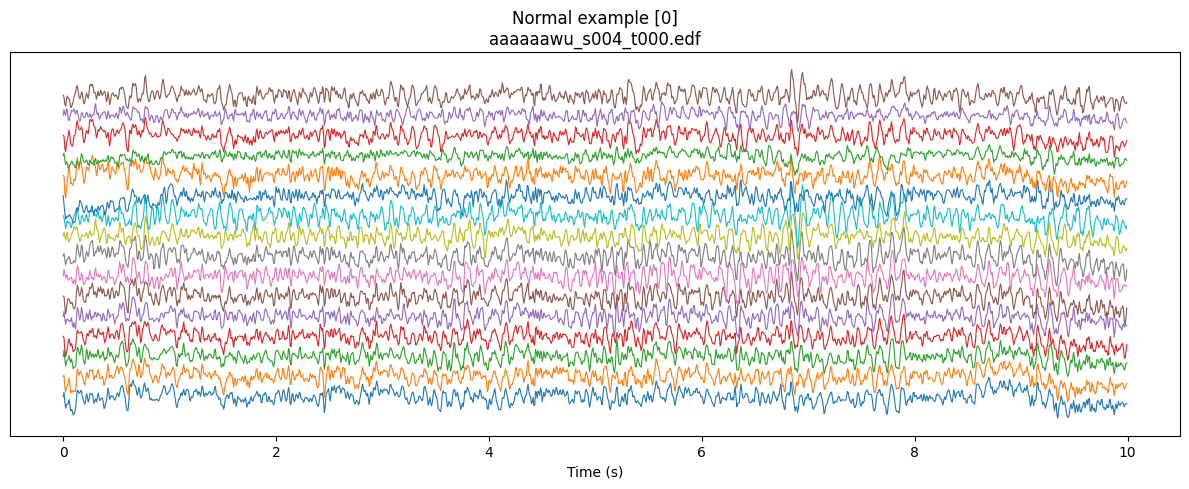

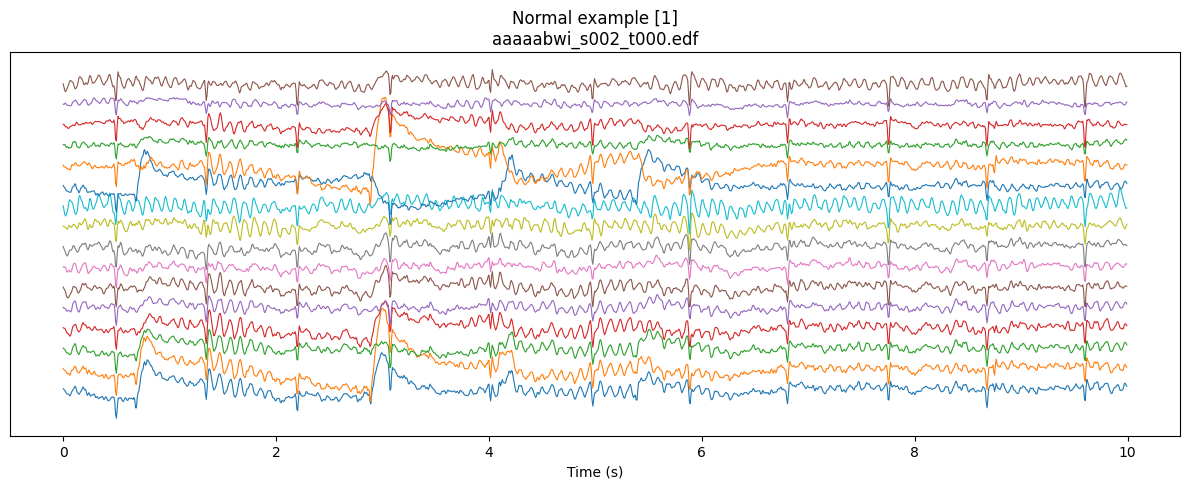

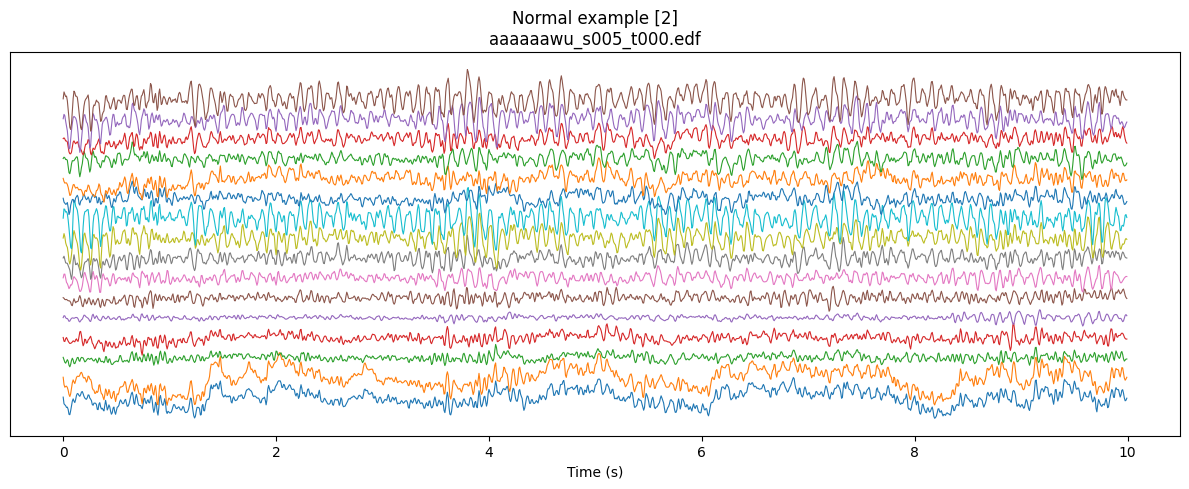

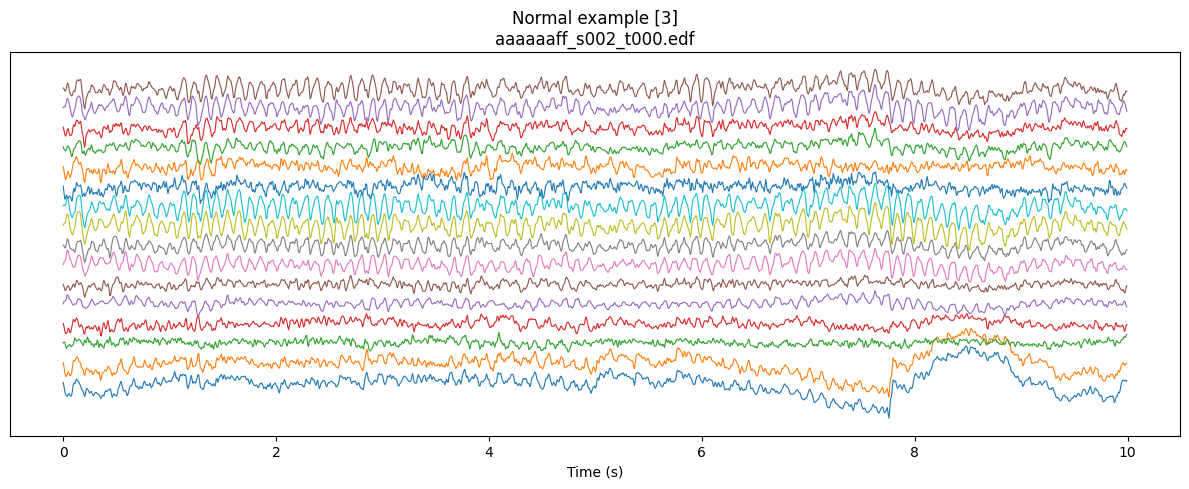

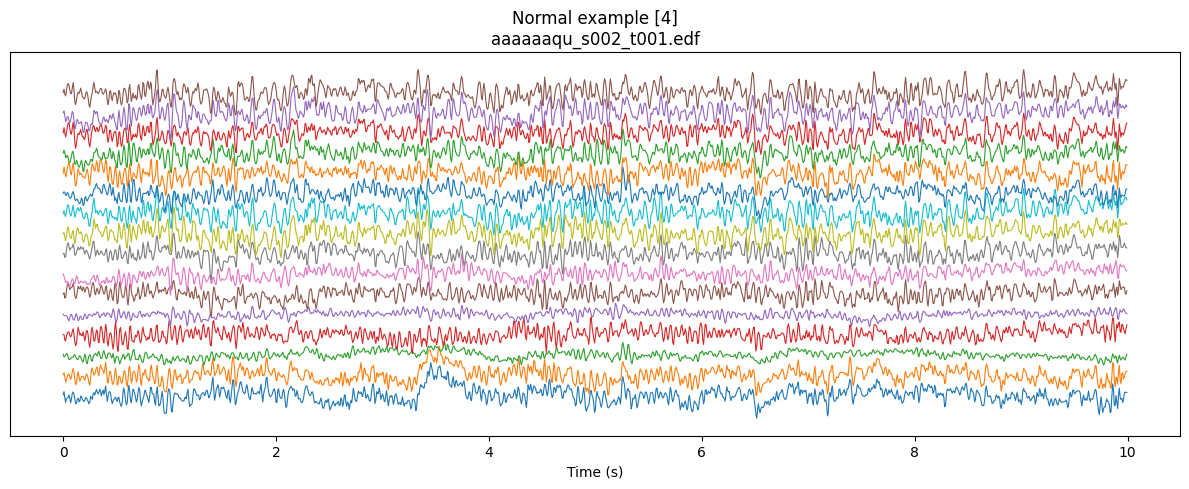

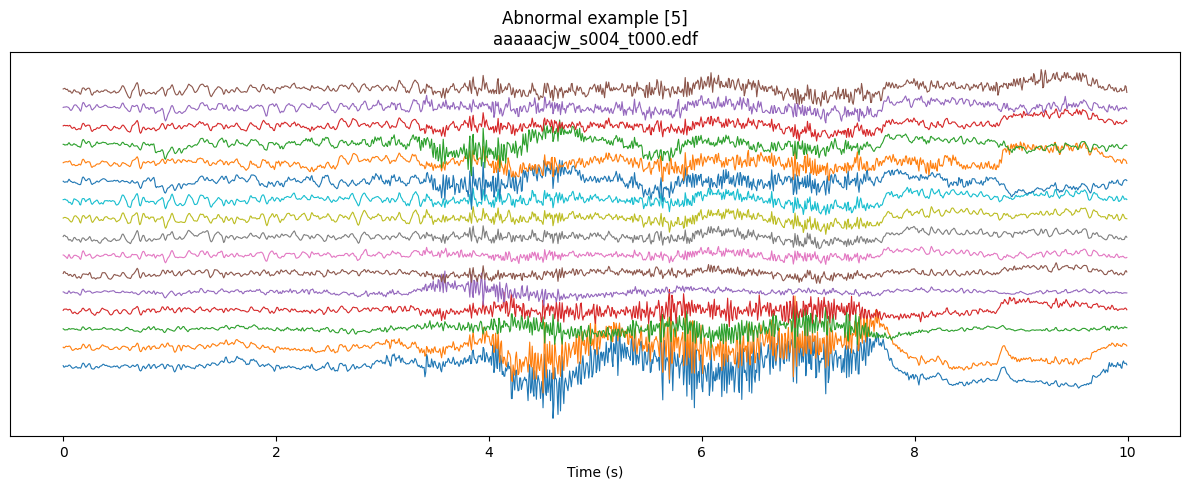

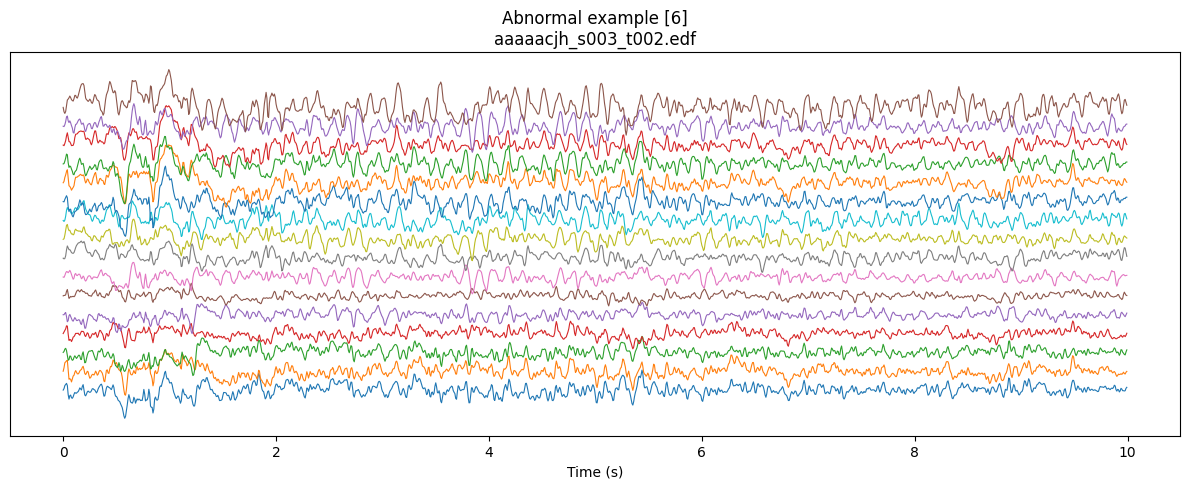

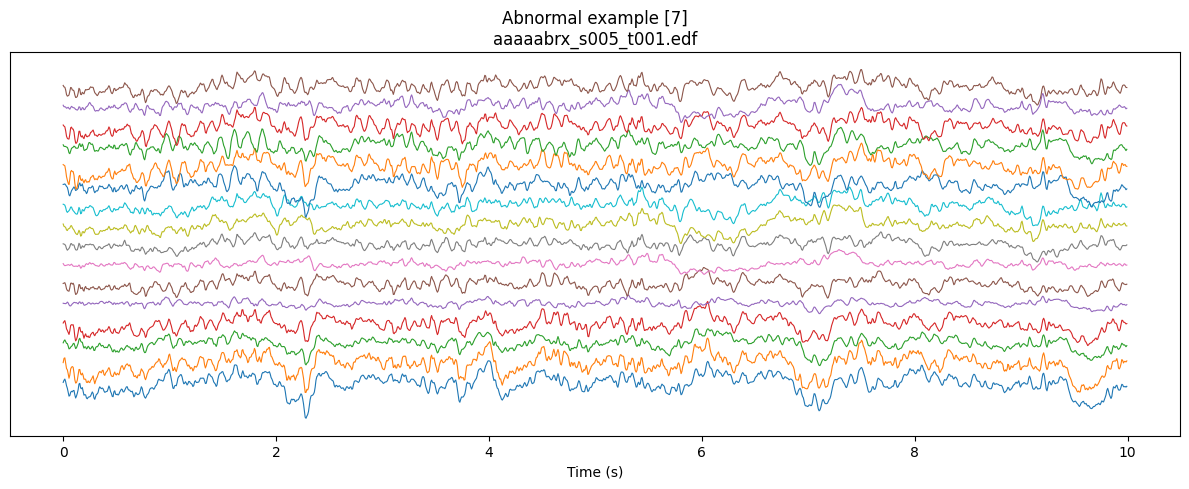

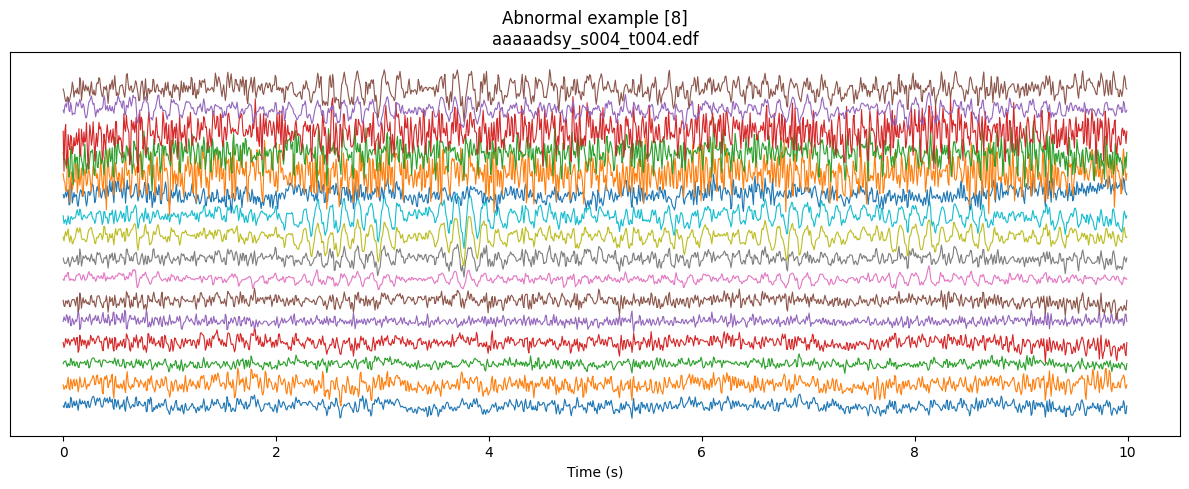

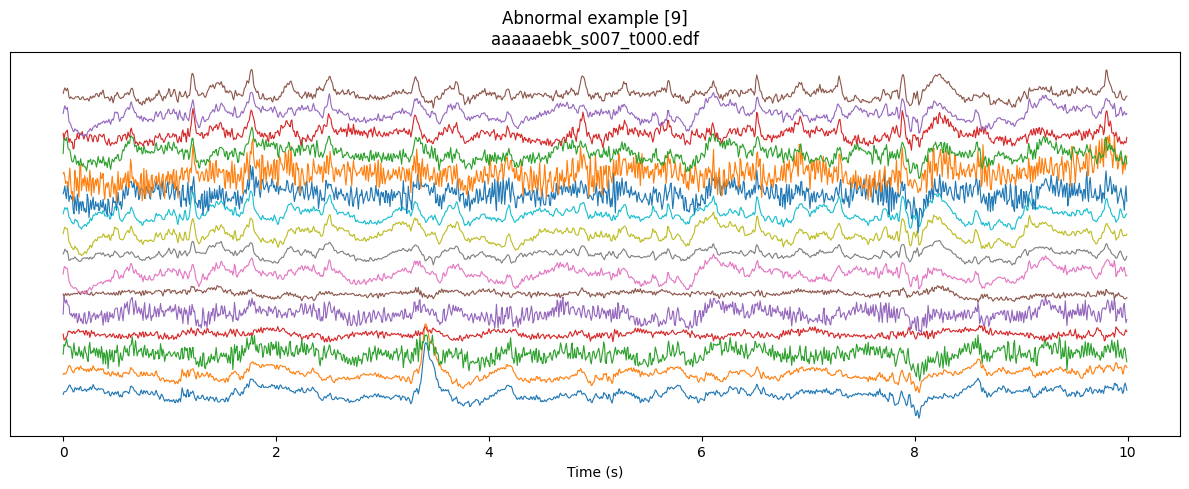

In [8]:
def plot_stacked(data_tc, sfreq=TARGET_SFREQ, seconds=10, title=""):
    T = min(int(seconds * sfreq), data_tc.shape[0])
    seg = data_tc[:T]
    t = np.arange(T) / sfreq

    offset = 3.0 * np.std(seg)
    plt.figure(figsize=(12, 5))
    for ch in range(seg.shape[1]):
        plt.plot(t, seg[:, ch] + ch * offset, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.yticks([])
    plt.title(title)
    plt.tight_layout()
    plt.show()

for i, (x, y, p) in enumerate(zip(recordings, labels, meta)):
    label_name = "Normal" if y == 0 else "Abnormal"
    fname = Path(p).name

    plot_stacked(
        x,
        title=f"{label_name} example [{i}]\n{fname}"
    )

In [9]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[1]
sys.path.append(str(project_root))

from EEGformer.models import EEGformer

In [ ]:
class WindowFromRecordingsDataset(Dataset):
    def __init__(self, recordings, rec_labels, win_len=120, stride=1):
        self.recordings = [x.astype(np.float32) for x in recordings]
        self.rec_labels = np.asarray(rec_labels).astype(np.int64)
        self.win_len = win_len
        self.stride = stride

        self.samples = []
        for r_idx, x in enumerate(self.recordings):
            T = x.shape[0]
            y = int(self.rec_labels[r_idx])
            if T < win_len:
                continue
            for start in range(0, T - win_len + 1, stride):
                self.samples.append((r_idx, start, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        r_idx, start, y = self.samples[idx]
        x = self.recordings[r_idx][start:start+self.win_len, :]  # (win_len, C)
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

In [11]:
def zscore_per_recording(recordings, eps=1e-6):
    out = []
    for x in recordings:  # (T, C)
        mu = x.mean(axis=0, keepdims=True)
        sd = x.std(axis=0, keepdims=True)
        xz = (x - mu) / (sd + eps)
        out.append(xz.astype(np.float32))
    return out

recordings_z = zscore_per_recording(recordings)

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

rec_labels = np.array(labels)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=0)
train_rec_idx, test_rec_idx = next(sss.split(np.zeros(len(rec_labels)), rec_labels))

print("Train rec:", np.bincount(rec_labels[train_rec_idx], minlength=2))
print("Test  rec:", np.bincount(rec_labels[test_rec_idx],  minlength=2))

Train rec: [3 4]
Test  rec: [2 1]


In [13]:
def subset_recordings(recs, labs, rec_indices):
    rec_indices = list(rec_indices)
    return [recs[i] for i in rec_indices], [labs[i] for i in rec_indices]

train_recs, train_labs = subset_recordings(recordings_z, labels, train_rec_idx)
test_recs,  test_labs  = subset_recordings(recordings_z, labels, test_rec_idx)

win_len = 120
stride = 16

train_ds = WindowFromRecordingsDataset(train_recs, train_labs, win_len=win_len, stride=stride)
test_ds  = WindowFromRecordingsDataset(test_recs,  test_labs,  win_len=win_len, stride=stride)

print("Train windows:", len(train_ds))
print("Test  windows:", len(test_ds))

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)

Train windows: 511
Test  windows: 219


In [14]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = torch.zeros(win_len, 16).to(device)

model = EEGformer(
    input=dummy_input,
    num_cls=2,
    input_channels=16,
    kernel_size=10,
    num_blocks=2,
    num_heads_RTM=3,
    num_heads_STM=3,
    num_heads_TTM=11,
    num_submatrices=3,
    CF_second=8,
    dtype=torch.float32
).to(device)

In [15]:
import json

out_dir = Path.cwd() / "eegformer_outputs"
out_dir.mkdir(parents=True, exist_ok=True)

def save_checkpoint(model, path):
    torch.save(model.state_dict(), str(path))

def save_history(history, path_json):
    with open(path_json, "w", encoding="utf-8") as f:
        json.dump(history, f, indent=2)

def plot_history(history, path_png):
    epochs = history["epoch"]

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["test_loss"], label="test_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(path_png, dpi=200)
    plt.close()

    path_png_acc = Path(str(path_png).replace("loss", "acc"))
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["test_acc"], label="test_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(path_png_acc, dpi=200)
    plt.close()


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)
max_grad_norm = 1.0

def forward_batch(model, xb):
    outs = []
    for i in range(xb.shape[0]):
        out = model(xb[i])
        if out.dim() == 2:
            out = out.squeeze(0)
        outs.append(out)
    return torch.stack(outs, dim=0)  # (B, num_cls)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    pred_hist = torch.zeros(2, dtype=torch.long)

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = forward_batch(model, xb)
        loss = loss_fn(logits, yb)
        pred = logits.argmax(dim=1)

        pred_hist += torch.bincount(pred.cpu(), minlength=2)

        total_loss += loss.item() * xb.size(0)
        total_correct += (pred == yb).sum().item()
        total += xb.size(0)

    print("pred_hist:", pred_hist.tolist())
    return total_loss / total, total_correct / total

def train(model, train_loader, test_loader, epochs=30, save_best=True):
    history = {"epoch": [], "train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_acc = -1.0
    best_path = out_dir / "eegformer_best.pt"

    for ep in range(1, epochs + 1):
        model.train()
        total_loss, total_correct, total = 0.0, 0, 0

        for step, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)

            logits = forward_batch(model, xb)
            loss = loss_fn(logits, yb)
            loss.backward()

            if ep == 1 and step == 0:
                last_name, last_p = None, None
                for name, p in model.named_parameters():
                    if p.requires_grad:
                        last_name, last_p = name, p
                print("DEBUG last param:", last_name,
                      "| grad None?", last_p.grad is None,
                      "| grad abs mean:", None if last_p.grad is None else last_p.grad.abs().mean().item())
                with torch.no_grad():
                    print("DEBUG logits mean/std:", logits.mean().item(), logits.std().item())

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            pred = logits.argmax(dim=1)
            total_loss += loss.item() * xb.size(0)
            total_correct += (pred == yb).sum().item()
            total += xb.size(0)

        train_loss = total_loss / total
        train_acc = total_correct / total

        test_loss, test_acc = evaluate(model, test_loader)

        history["epoch"].append(ep)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        if save_best and test_acc > best_test_acc:
            best_test_acc = test_acc
            save_checkpoint(model, best_path)

        print(f"Epoch {ep:03d} | train loss {train_loss:.4f} acc {train_acc:.3f} "
              f"| test loss {test_loss:.4f} acc {test_acc:.3f}")

    last_path = out_dir / "eegformer_last.pt"
    save_checkpoint(model, last_path)
    hist_path = out_dir / "train_history.json"
    save_history(history, hist_path)
    plot_history(history, out_dir / "train_curve_loss.png")

    print(f"\nSaved last checkpoint to: {last_path}")
    if save_best:
        print(f"Saved best checkpoint to: {best_path} (best test acc = {best_test_acc:.3f})")
    print(f"Saved training history to: {hist_path}")
    print(f"Saved curves to: {out_dir / 'train_curve_loss.png'} and train_curve_acc.png")

    return history

history = train(model, train_loader, test_loader, epochs=30)

test_loss, test_acc = evaluate(model, test_loader)
print(f"TEST | loss {test_loss:.4f} acc {test_acc:.3f}")

DEBUG last param: cnndecoder.fc.bias | grad None? False | grad abs mean: 0.02352166175842285
DEBUG logits mean/std: -0.012173956260085106 0.049215953797101974
pred_hist: [93, 126]
Epoch 001 | train loss 0.5534 acc 0.730 | test loss 0.7098 acc 0.703
pred_hist: [65, 154]
Epoch 002 | train loss 0.2622 acc 0.916 | test loss 1.2720 acc 0.630
pred_hist: [80, 139]
Epoch 003 | train loss 0.0405 acc 0.992 | test loss 1.7082 acc 0.689
pred_hist: [119, 100]
Epoch 004 | train loss 0.0198 acc 0.992 | test loss 0.9134 acc 0.831
pred_hist: [29, 190]
Epoch 005 | train loss 0.0008 acc 1.000 | test loss 3.9842 acc 0.466
pred_hist: [142, 77]
Epoch 006 | train loss 0.0486 acc 0.984 | test loss 0.6197 acc 0.863
pred_hist: [38, 181]
Epoch 007 | train loss 0.0573 acc 0.986 | test loss 1.8680 acc 0.507
pred_hist: [70, 149]
Epoch 008 | train loss 0.0176 acc 0.992 | test loss 2.3733 acc 0.653
pred_hist: [36, 183]
Epoch 009 | train loss 0.0089 acc 0.996 | test loss 4.0112 acc 0.498
pred_hist: [68, 151]
Epoch 010